In [1]:
import os
import json
import sys
import cv2
import numpy as np

In [2]:
root = '/checkpoint/apratik/finals/default/apartment_0/'

def make_data(root, img_indx):
    src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
    src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]
    cur_pose = base_pose_data["{}".format(img_indx+5)]
    cur_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx+5)))
    cur_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx+5)))
    print(f'{type(src_img), type(src_depth), type(src_label)}')
    # Visualize label
    return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cur_label
    
src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cur_label = make_data(root, 1)

hello_root = '/checkpoint/apratik/robot_trajectories/active/1/'
def get_hello_data(root, img_indx):
    src_img = cv2.imread(os.path.join(hello_root, f"rgb/{img_indx}.jpg"))
    src_depth = np.load(os.path.join(hello_root, f"depth/{img_indx}.npy"))
    src_label = np.load(os.path.join(hello_root, f"seg/{img_indx}.npy"))
    with open(os.path.join(hello_root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]['base_xyt']
    cur_pose = base_pose_data["{}".format(img_indx+5)]['base_xyt']
    cur_depth = np.load(os.path.join(hello_root, f"depth/{img_indx+5}.npy"))
    # cur_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx+5)))
    print(f'{type(src_img), type(src_depth), type(src_label)}')
    # Visualize label
    return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth
    
src_img, src_depth, src_label, src_pose, cur_pose, cur_depth = get_hello_data(root, 100)


from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

from utils import d3_40_colors_rgb

def display_sample(src_img, semantic1, semantic2):
    
    arr = [src_img]
    for semantic_obs in [semantic1, semantic2]:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)

    titles = ['src_img', 'src', 'propagated']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

from droidlet.lowlevel.robot_mover_utils import transform_pose
from copy import deepcopy as copy
from numba import njit
import random
from math import floor, ceil

"""
1. Find pixel index for each label, keep the pts list pts_in_world
2. for each set, transform pts_in_world to current image frame
3. Do filteration - if norm(original pixel - current pixel) is greater than threshold, set it to false
4. Do quantization fix 

"""

def _process(filtered_img_indx, req_pts_in_world, pts_in_cur_img, kernel_size, height, width, cur_pts_in_world, dist_thr):
#     for pixel_index in range(len(filtered_img_indx)):
#         if filtered_img_indx[pixel_index]:
#             # search in the region
#             gt_pix_depth_in_world = req_pts_in_world[pixel_index]
#             # print(f'gt_pix_depth_in_world {gt_pix_depth_in_world}')
#             # print(f'pts_in_cur_img[pixel_index] {pts_in_cur_img[pixel_index]}')
#             p, q = np.meshgrid(
#                 range(
#                     int(pts_in_cur_img[pixel_index][1] - kernel_size),
#                     int(pts_in_cur_img[pixel_index][1] + kernel_size),
#                 ),
#                 range(
#                     int(pts_in_cur_img[pixel_index][0] - kernel_size),
#                     int(pts_in_cur_img[pixel_index][0] + kernel_size),
#                 ),
#             )
#             loc = p * width + q
#             # print(f'meshgrid p {p.shape} q {q.shape}')
#             # print(f'loc {loc.shape}')
# #                 
#             loc = loc.reshape(-1).astype(np.int32)
#             # print(f'loc {loc}')
#             loc = np.clip(loc, 0, width * height - 1).astype(np.int32)

#             if (
#                 min(np.linalg.norm(cur_pts_in_world[loc] - gt_pix_depth_in_world, axis=1))
#                 > dist_thr
#             ):
#                 filtered_img_indx[pixel_index] = False
            
#             else:
#                 filtered_img_indx[pixel_index] = True

    # take out filtered pix values
    pts_in_cur_img = pts_in_cur_img[filtered_img_indx]

    # print(f'pts_in_cur_img pre quantfix {pts_in_cur_img.shape}')

    # pts_in_cur_img = stochastic_round(pts_in_cur_img)

    # step to take care of quantization errors
    pts_in_cur_img = quantization_fix(pts_in_cur_img)

    # print(f'pts_in_cur_img post quantfix {pts_in_cur_img.shape}')
    pts_in_cur_img = pts_in_cur_img[:, :2].astype(int)
    
    return pts_in_cur_img

def compute_uvone(height, width):
    intrinsic_mat = np.array([[256, 0, 256], [0, 256, 256], [0, 0, 1]])
    rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
    trans = np.array([0, 0, 0.6])
    # precompute some values necessary to depth to point cloud
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    return uv_one_in_cam, intrinsic_mat, rot, trans

def convert_depth_to_pcd(depth, pose, uv_one_in_cam, rot, trans):
    # point cloud in camera frame
    depth = (depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, pose)
    return pts_in_world

@njit
def get_annot(height, width, pts_in_cur_img, src_label):
    annot_img = np.zeros((height, width))
    
    def get_row_col(x, h, w):
        # x = r*w + c
        r = int(x/w)
        c = int(x - r*w)
        # print(f'p {x} r {r} c {c}')
        return r, c
    
    for x in range(len(pts_in_cur_img)):
        r, c = get_row_col(x, height, width)
        x, y, _ = pts_in_cur_img[x]
        # print(f'r,c {r,c} x,y {x,y}')
        if floor(x) >= 0 and ceil(x) < height and floor(y) >=0 and ceil(y) < width:
            annot_img[ceil(y)][ceil(x)] = src_label[r][c]
            annot_img[floor(y)][floor(x)] = src_label[r][c]
            annot_img[ceil(y)][floor(x)] = src_label[r][c]
            annot_img[floor(y)][ceil(x)] = src_label[r][c]
    
    return annot_img
    

def label_prop(
    src_img,
    src_depth,
    src_label,
    src_pose,
    base_pose,
    cur_depth,
):
    ### data needed to convert depth img to pointcloud ###
    # values extracted from pyrobot habitat agent
    height, width, _ = src_img.shape
    uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width)
    pts_in_world = convert_depth_to_pcd(src_depth, src_pose, uv_one_in_cam, rot, trans)
    cur_pts_in_world = convert_depth_to_pcd(cur_depth, base_pose, uv_one_in_cam, rot, trans)
    
    # convert pts_in_world to current base
    pts_in_cur_base = transform_pose(pts_in_world, (-base_pose[0], -base_pose[1], 0))
    pts_in_cur_base = transform_pose(pts_in_cur_base, (0.0, 0.0, -base_pose[2]))

    # conver point from current base to current camera frame
    pts_in_cur_cam = pts_in_cur_base - trans.reshape(-1)
    pts_in_cur_cam = np.dot(pts_in_cur_cam, rot)

    # conver pts in current camera frame into 2D pix values
    pts_in_cur_img = np.matmul(intrinsic_mat, pts_in_cur_cam.T).T
    print(f'pts_in_cur_img.shape {pts_in_cur_img[:3]}, pts_in_world.shape {pts_in_world.shape, pts_in_world[:3]}') 
    pts_in_cur_img /= pts_in_cur_img[:, 2].reshape([-1, 1])
    print(f'pts_in_cur_img.shape {pts_in_cur_img[:3]}') 
    
    return get_annot(height, width, pts_in_cur_img, src_label)


(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


pts_in_cur_img.shape [[-10.78387867 -10.58142467   2.13866638]
 [ -8.59739596 -10.58127855   2.14566692]
 [ -6.3806073  -10.58197373   2.16166423]], pts_in_world.shape ((307200, 3), array([[-1.32974132,  5.4439708 ,  2.78000007],
       [-1.3260564 ,  5.45011911,  2.78700004],
       [-1.32793116,  5.46761898,  2.80300007]]))
pts_in_cur_img.shape [[-5.04233797 -4.9476743   1.        ]
 [-4.0068642  -4.93146372  1.        ]
 [-2.95171063 -4.89529019  1.        ]]
time 0.5646748542785645


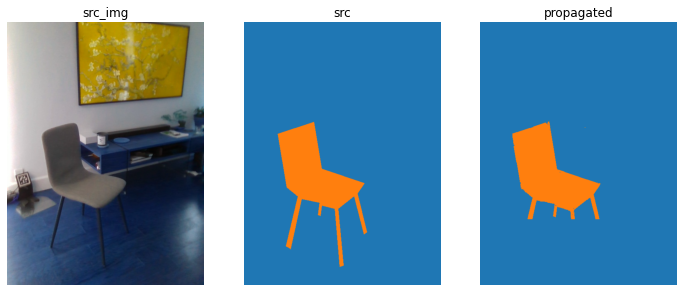

In [3]:
import time

start = time.time()
label = label_prop(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
end = time.time()
print(f'time {end-start}')
display_sample(src_img, src_label, label)

In [4]:
cur_pose

[0.05850251561624731, 2.7232132001715996, 1.2474535150346964]

In [5]:
"""
high level overview

input
src_img,
src_depth,
src_label,
src_pose,
base_pose,
cur_depth,


take sdepth + spose -> spts in world
for each label, take lpts and transform it to cur_base -> cur_cam 


"""

'\nhigh level overview\n\ninput\nsrc_img,\nsrc_depth,\nsrc_label,\nsrc_pose,\nbase_pose,\ncur_depth,\n\n\ntake sdepth + spose -> spts in world\nfor each label, take lpts and transform it to cur_base -> cur_cam \n\n\n'